In [1]:
!pip install transformers

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

In [3]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers

In [4]:
from tqdm import tqdm, trange

In [5]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(device, n_gpu)
torch.cuda.get_device_name()

cuda 1


'Tesla T4'

In [10]:
# getting the data
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
root_path = "/content/drive/MyDrive/Colab Notebooks/Learning Transformers /cola_public"
file_path = root_path + '/raw/in_domain_train.tsv'
df = pd.read_csv(file_path,
                 delimiter = "\t",
                 header=None,
                 names = ["sentence_source", "label", "label_notes", "sentence"]
                 )
df.head(2), df.shape

(  sentence_source  label label_notes                                           sentence
 0            gj04      1         NaN  Our friends won't buy this analysis, let alone...
 1            gj04      1         NaN  One more pseudo generalization and I'm giving up.,
 (8551, 4))

In [14]:
df.sample(5)

,sentence_source,label,label_notes,sentence
5638,c_13,1,NaN,It is obvious to everybody that Tasha likes Mi...
7231,sks13,1,NaN,Bill's mother's friends are waiting at the res...
4525,ks08,1,NaN,"They can't do it, can they?"
4442,ks08,1,NaN,He has seen his children.
454,bc01,0,*,I wonder who what bought?


# Columns and Significance

- label
        : 1, Acceptable
        : 0, Unacceptable


In [27]:
sentences = df.sentence.values
len(sentences)

8551

In [28]:
sentences[100:105]

array(['If you eat more, you want correspondingly less.',
       'When you eat more, you want correspondingly less.',
       'As you eat more, you want correspondingly less.',
       'The most you want, the least you eat.',
       'The angrier Sue gets, the more Fred admires her.'], dtype=object)

In [29]:
# adding CLS and SEP for separation of sentences
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values
set(labels) # denotes the total unique labels

{0, 1}

In [30]:
# BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [31]:
tokenized_texts = [tokenizer.tokenize(sentence_) for sentence_ in sentences]
tokenized_texts[0], sentences[0]

(['[CLS]',
  'our',
  'friends',
  'won',
  "'",
  't',
  'buy',
  'this',
  'analysis',
  ',',
  'let',
  'alone',
  'the',
  'next',
  'one',
  'we',
  'propose',
  '.',
  '[SEP]'],
 "[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]")

In [32]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids[0]

[101,
 2256,
 2814,
 2180,
 1005,
 1056,
 4965,
 2023,
 4106,
 1010,
 2292,
 2894,
 1996,
 2279,
 2028,
 2057,
 16599,
 1012,
 102]

In [33]:
# padding
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids[0]

array([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,
        1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [38]:
# attention masks
# no attention on the padded tokens tho, so? apply mask of 1 for words, 0 for padding
attention_masks = []

for sequence in input_ids:
    sequence_mask = [float(i>0) for i in sequence] # separating padding and the inputs
    attention_masks.append(sequence_mask)
print(len(attention_masks[0]), attention_masks[0])

128 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [41]:
train_X, test_X, train_y, test_y = train_test_split(input_ids, labels,  random_state = 10, test_size=0.2)
train_mask, test_mask, _, _  = train_test_split(attention_masks, input_ids, random_state = 10, test_size=0.2)
len(train_X), len(test_X), len(train_y), len(test_y), len(train_mask), len(test_mask)

(6840, 1711, 6840, 1711, 6840, 1711)

In [42]:
train_X = torch.tensor(train_X)
test_X = torch.tensor(test_X)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
train_mask = torch.tensor(train_mask)
test_mask = torch.tensor(test_mask)

In [45]:
# bs and iterator
batch_size = 32
train_data = TensorDataset(train_X, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

In [47]:
test_data = TensorDataset(test_X, test_mask, test_y)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = batch_size)
train_data, test_data

(<torch.utils.data.dataset.TensorDataset at 0x7832933613f0>,
 <torch.utils.data.dataset.TensorDataset at 0x7832933615d0>)

## Model Configuration (BERT)

In [52]:
config =  transformers.BertConfig()
print(f'Config is as:\n{config}')

# bert-base-uncased
model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Config is as:
BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

- pad_token_id : 0 means to avoid tokens with index having attention mask 0 since they are just padding

### Optimizing grouped parameters

In [56]:
param_optimizer = list(model.named_parameters())

no_decay = ["bias", "LayerNorm.weight"] # separating weight parameters from bias parameters

optimizer_grouped_parameters = [
    {
        "params":[p for  n,  p  in param_optimizer if not any(nd in n for nd in no_decay)],
        "weight_decay_rate":0.0
    }
]

In [65]:
optimizer = torch.optim.AdamW(optimizer_grouped_parameters,
                              lr=2e-5
                              )
epochs = 10

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = transformers.get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

scheduler, optimizer, total_steps

(<torch.optim.lr_scheduler.LambdaLR at 0x7832874d2890>,
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 2e-05
     lr: 2e-05
     maximize: False
     weight_decay: 0.01
     weight_decay_rate: 0.0
 ),
 2140)

In [66]:
def flattened_accuracy(preds, labels):
    preds_flattened = np.argmax(preds, axis=1).flatten()
    labels_flattened = labels.flatten()
    return np.sum(preds_flattened == labels_flattened )/len(labels_flattened)

##  training

In [67]:
t = []

train_losses = []

for _ in trange(epochs, desc="Epoch"):
    # Training

    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0


    for step, input_data in enumerate(train_dataloader):

        input_data = tuple(t.to(device) for t in input_data)

        b_input_ids, b_input_mask, b_labels = input_data
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs['loss']
        train_losses.append(loss.item())

        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for input_data in test_dataloader:

        input_data = tuple(t.to(device) for t in input_data)

        b_input_ids, b_input_mask, b_labels = input_data
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():

            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)


        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flattened_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.49854208730927135


Epoch:  10%|█         | 1/10 [02:26<21:58, 146.52s/it]

Validation Accuracy: 0.7850694444444444
Train loss: 0.2931043198593309


Epoch:  20%|██        | 2/10 [04:49<19:13, 144.16s/it]

Validation Accuracy: 0.8229166666666666
Train loss: 0.1663140563172436


Epoch:  30%|███       | 3/10 [07:11<16:44, 143.47s/it]

Validation Accuracy: 0.8130015432098765
Train loss: 0.10379731179014823


Epoch:  40%|████      | 4/10 [09:34<14:18, 143.06s/it]

Validation Accuracy: 0.8192901234567901
Train loss: 0.08283747915204649


Epoch:  50%|█████     | 5/10 [11:56<11:53, 142.79s/it]

Validation Accuracy: 0.823341049382716
Train loss: 0.052977012411612914


Epoch:  60%|██████    | 6/10 [14:18<09:30, 142.61s/it]

Validation Accuracy: 0.8245756172839506
Train loss: 0.03668644683975204


Epoch:  70%|███████   | 7/10 [16:40<07:07, 142.51s/it]

Validation Accuracy: 0.8227623456790124
Train loss: 0.029170758170336833


Epoch:  80%|████████  | 8/10 [19:03<04:44, 142.46s/it]

Validation Accuracy: 0.8297067901234568
Train loss: 0.019359188153251796


Epoch:  90%|█████████ | 9/10 [21:25<02:22, 142.43s/it]

Validation Accuracy: 0.8333333333333334
Train loss: 0.01981383029895913


Epoch: 100%|██████████| 10/10 [23:48<00:00, 142.81s/it]

Validation Accuracy: 0.8297839506172839


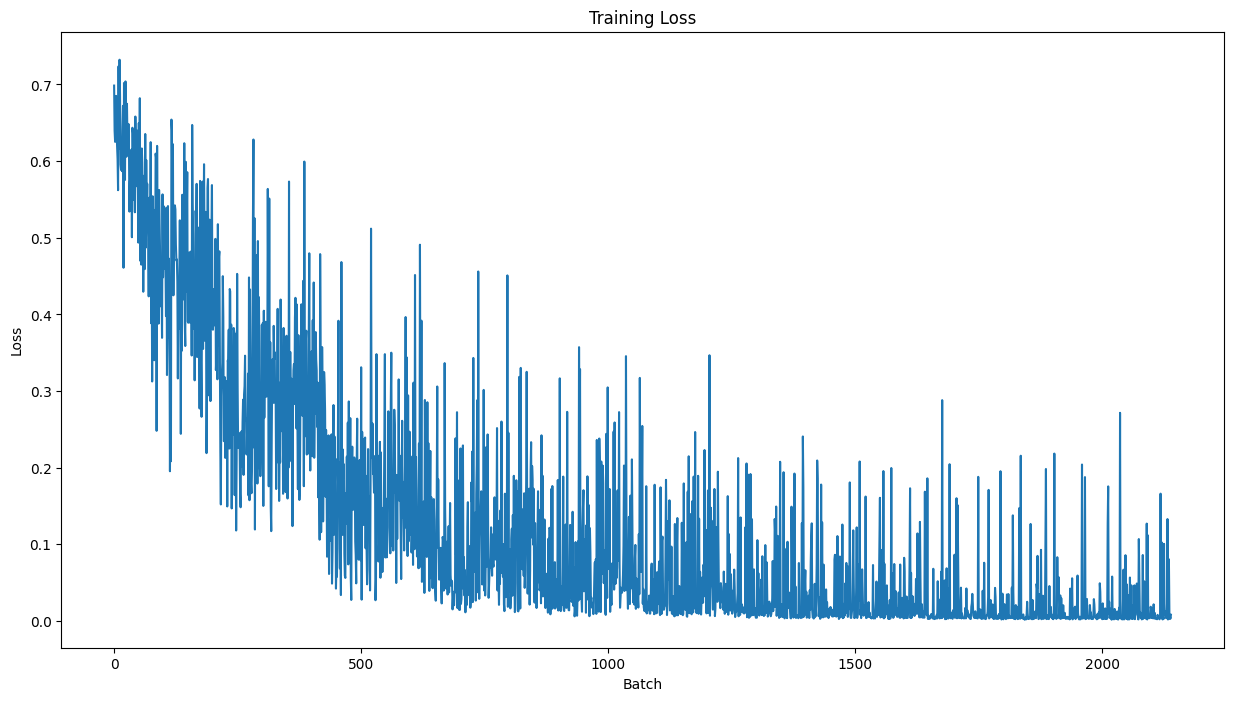

In [68]:
plt.figure(figsize=(15,8))
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_losses)
plt.show()

# predicting

In [69]:
file_path = root_path + '/raw/out_of_domain_dev.tsv'
df_test = pd.read_csv(file_path,
                 delimiter = "\t",
                 header=None,
                 names = ["sentence_source", "label", "label_notes", "sentence"]
                 )
df_test.head(2), df_test.shape

(  sentence_source  label label_notes                                           sentence
 0           clc95      1         NaN                    Somebody just left - guess who.
 1           clc95      1         NaN  They claimed they had settled on something, bu...,
 (516, 4))

In [72]:
sentences = df_test.sentence.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels =  df_test.label.values

tokenized_texts = [tokenizer.tokenize(sentence) for sentence in sentences]


MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [73]:
model.eval()

predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

## Matthews Correlation Coefficient

$$
MCC =  \frac{TP*TN - FP * FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
$$

In [76]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i], np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

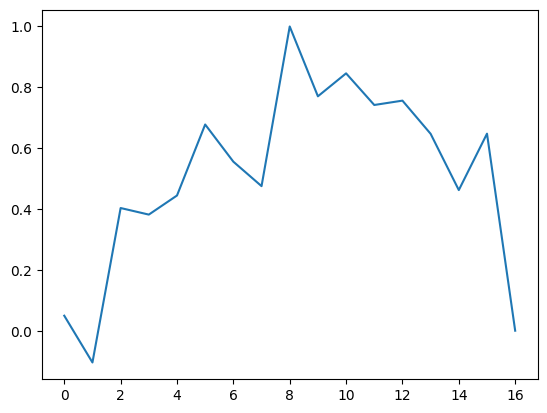

In [77]:
plt.plot(matthews_set)

All MCC values are greater than 0, hence good result.

In [78]:
# for whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.550529505732458